# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()]) 
    image_dataset = datasets.ImageFolder(data_dir, transform)
    return torch.utils.data.DataLoader(image_dataset, batch_size = batch_size, shuffle=True)

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

/opt/anaconda/envs/depp_learn_training/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


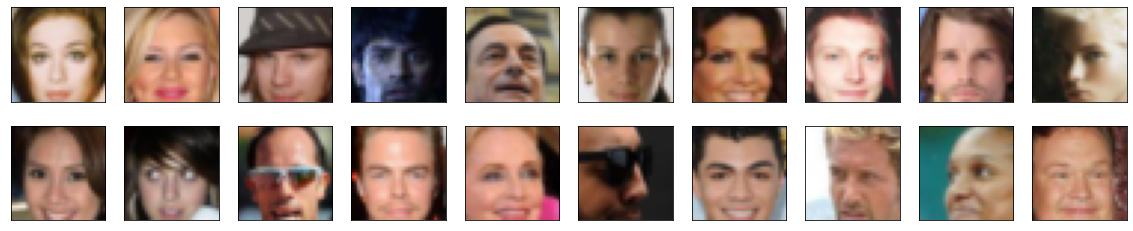

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = (max - min)*x + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.8980)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers=[]
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                          stride=stride, padding=padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [39]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, kernel_size=4, batch_norm=False)
        self.conv2 = conv(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, batch_norm=True)
        self.conv3 = conv(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, batch_norm=True)
        self.conv4 = conv(in_channels=conv_dim*4, out_channels=conv_dim*8, kernel_size=4, batch_norm=True)
        self.fcl = nn.Linear(conv_dim*8*2*2, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = x.view(-1, self.conv_dim*8*2*2)
        x = self.fcl(x)
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [40]:
def deconv(in_channel, out_channel, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size,
                                     stride=stride, padding=padding, bias=False)
    layers.append(deconv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channel))
    return nn.Sequential(*layers)

In [41]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.fcl = nn.Linear(z_size, conv_dim*8*2*2)
        self.deconv1 = deconv(in_channel=conv_dim*8, out_channel=conv_dim*4, kernel_size=4, batch_norm=True)
        self.deconv2 = deconv(in_channel=conv_dim*4, out_channel=conv_dim*2, kernel_size=4, batch_norm=True)
        self.deconv3 = deconv(in_channel=conv_dim*2, out_channel=conv_dim, kernel_size=4, batch_norm=True)
        self.deconv4 = deconv(in_channel=conv_dim, out_channel=3, kernel_size=4, batch_norm=False)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        x = self.fcl(x)
        x = x.view(-1, self.conv_dim*8, 2, 2)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.tanh(self.deconv4(x))
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/opt/anaconda/envs/depp_learn_training/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [42]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    isConvLayer = classname.find('Conv') != -1
    isLinearLayer = classname.find('Linear') != -1
    if (isConvLayer or isLinearLayer):
        nn.init.normal_(m.weight.data, mean=0, std=0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [66]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fcl): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fcl): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=F

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [68]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [69]:
import torch.optim as optim
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [70]:
def generate_z(batch_size, z_size):
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = z.cuda()
    return z

In [71]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            real_images = real_images.cuda()
            d_real_images = D(real_images)
            d_real_loss = real_loss(d_real_images)
            fake_images = G(generate_z(batch_size, z_size))
            d_fake_image = D(fake_images)
            d_fake_loss = fake_loss(d_fake_image)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            fake_images = G(generate_z(batch_size, z_size))
            g_fake_image = D(fake_images)
            g_loss = real_loss(g_fake_image)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [72]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

/opt/anaconda/envs/depp_learn_training/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3847 | g_loss: 2.3104
Epoch [    1/  100] | d_loss: 0.0989 | g_loss: 5.1501
Epoch [    1/  100] | d_loss: 0.1944 | g_loss: 5.7405
Epoch [    1/  100] | d_loss: 0.6086 | g_loss: 5.6336
Epoch [    1/  100] | d_loss: 0.7844 | g_loss: 5.3778
Epoch [    1/  100] | d_loss: 0.5952 | g_loss: 2.9478
Epoch [    1/  100] | d_loss: 0.8467 | g_loss: 5.6076
Epoch [    1/  100] | d_loss: 0.6724 | g_loss: 3.0248
Epoch [    1/  100] | d_loss: 0.5225 | g_loss: 2.9892
Epoch [    1/  100] | d_loss: 0.5722 | g_loss: 2.6146
Epoch [    1/  100] | d_loss: 0.5370 | g_loss: 2.0404
Epoch [    1/  100] | d_loss: 0.5184 | g_loss: 3.3088
Epoch [    1/  100] | d_loss: 0.5933 | g_loss: 3.8541
Epoch [    1/  100] | d_loss: 1.4007 | g_loss: 3.2882
Epoch [    1/  100] | d_loss: 0.6685 | g_loss: 2.6064
Epoch [    2/  100] | d_loss: 0.6576 | g_loss: 2.6298
Epoch [    2/  100] | d_loss: 0.5368 | g_loss: 2.5035
Epoch [    2/  100] | d_loss: 0.6561 | g_loss: 2.1445
Epoch [    2/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.4736 | g_loss: 1.6511
Epoch [   11/  100] | d_loss: 0.2762 | g_loss: 2.3104
Epoch [   11/  100] | d_loss: 0.2199 | g_loss: 4.8176
Epoch [   11/  100] | d_loss: 0.4881 | g_loss: 2.4091
Epoch [   11/  100] | d_loss: 0.4749 | g_loss: 1.1443
Epoch [   11/  100] | d_loss: 0.3908 | g_loss: 3.5457
Epoch [   11/  100] | d_loss: 0.1512 | g_loss: 4.6146
Epoch [   11/  100] | d_loss: 1.1517 | g_loss: 3.2743
Epoch [   11/  100] | d_loss: 0.4531 | g_loss: 4.9066
Epoch [   11/  100] | d_loss: 1.4521 | g_loss: 6.2451
Epoch [   11/  100] | d_loss: 0.5640 | g_loss: 3.5323
Epoch [   11/  100] | d_loss: 0.2997 | g_loss: 2.3703
Epoch [   11/  100] | d_loss: 0.7349 | g_loss: 3.7998
Epoch [   12/  100] | d_loss: 0.3262 | g_loss: 1.2354
Epoch [   12/  100] | d_loss: 0.3377 | g_loss: 2.0496
Epoch [   12/  100] | d_loss: 0.6075 | g_loss: 2.7337
Epoch [   12/  100] | d_loss: 0.6486 | g_loss: 3.9887
Epoch [   12/  100] | d_loss: 0.4691 | g_loss: 1.3173
Epoch [   12/  100] | d_loss

Epoch [   21/  100] | d_loss: 0.1972 | g_loss: 3.2465
Epoch [   21/  100] | d_loss: 0.1733 | g_loss: 5.9395
Epoch [   21/  100] | d_loss: 0.2322 | g_loss: 2.8274
Epoch [   21/  100] | d_loss: 0.1498 | g_loss: 2.8767
Epoch [   21/  100] | d_loss: 0.2217 | g_loss: 2.3337
Epoch [   21/  100] | d_loss: 0.1293 | g_loss: 6.4320
Epoch [   21/  100] | d_loss: 0.0664 | g_loss: 3.0782
Epoch [   21/  100] | d_loss: 0.0992 | g_loss: 4.1791
Epoch [   21/  100] | d_loss: 0.3288 | g_loss: 5.4744
Epoch [   21/  100] | d_loss: 0.2384 | g_loss: 3.3962
Epoch [   21/  100] | d_loss: 0.0427 | g_loss: 4.2264
Epoch [   22/  100] | d_loss: 0.1198 | g_loss: 2.6787
Epoch [   22/  100] | d_loss: 0.4334 | g_loss: 3.6593
Epoch [   22/  100] | d_loss: 0.2074 | g_loss: 6.0791
Epoch [   22/  100] | d_loss: 0.1788 | g_loss: 2.4739
Epoch [   22/  100] | d_loss: 0.0573 | g_loss: 3.2027
Epoch [   22/  100] | d_loss: 0.1657 | g_loss: 3.0251
Epoch [   22/  100] | d_loss: 0.3800 | g_loss: 7.2032
Epoch [   22/  100] | d_loss

Epoch [   31/  100] | d_loss: 1.3633 | g_loss: 2.1297
Epoch [   31/  100] | d_loss: 0.1146 | g_loss: 9.0248
Epoch [   31/  100] | d_loss: 0.3653 | g_loss: 4.8365
Epoch [   31/  100] | d_loss: 0.0597 | g_loss: 5.6296
Epoch [   31/  100] | d_loss: 0.0089 | g_loss: 5.2749
Epoch [   31/  100] | d_loss: 0.0548 | g_loss: 4.0722
Epoch [   31/  100] | d_loss: 0.4362 | g_loss: 7.6908
Epoch [   31/  100] | d_loss: 0.0276 | g_loss: 4.4569
Epoch [   31/  100] | d_loss: 0.3112 | g_loss: 3.8338
Epoch [   32/  100] | d_loss: 0.0931 | g_loss: 5.0395
Epoch [   32/  100] | d_loss: 0.0374 | g_loss: 9.3285
Epoch [   32/  100] | d_loss: 0.0752 | g_loss: 4.8960
Epoch [   32/  100] | d_loss: 0.0898 | g_loss: 4.8876
Epoch [   32/  100] | d_loss: 0.3155 | g_loss: 5.3701
Epoch [   32/  100] | d_loss: 0.0662 | g_loss: 4.6007
Epoch [   32/  100] | d_loss: 0.1859 | g_loss: 4.3133
Epoch [   32/  100] | d_loss: 0.0761 | g_loss: 5.9295
Epoch [   32/  100] | d_loss: 0.0160 | g_loss: 4.1372
Epoch [   32/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.0294 | g_loss: 4.3176
Epoch [   41/  100] | d_loss: 0.1665 | g_loss: 8.4967
Epoch [   41/  100] | d_loss: 0.0778 | g_loss: 6.1510
Epoch [   41/  100] | d_loss: 0.4793 | g_loss: 6.9257
Epoch [   41/  100] | d_loss: 0.2417 | g_loss: 2.3570
Epoch [   41/  100] | d_loss: 0.0181 | g_loss: 6.0302
Epoch [   41/  100] | d_loss: 0.0915 | g_loss: 3.1527
Epoch [   42/  100] | d_loss: 0.0395 | g_loss: 7.6922
Epoch [   42/  100] | d_loss: 0.0476 | g_loss: 4.9111
Epoch [   42/  100] | d_loss: 0.2928 | g_loss: 1.9149
Epoch [   42/  100] | d_loss: 0.0492 | g_loss: 5.3212
Epoch [   42/  100] | d_loss: 3.0932 | g_loss: 10.6132
Epoch [   42/  100] | d_loss: 0.5085 | g_loss: 6.6799
Epoch [   42/  100] | d_loss: 0.1126 | g_loss: 6.5920
Epoch [   42/  100] | d_loss: 0.0103 | g_loss: 4.0869
Epoch [   42/  100] | d_loss: 0.0959 | g_loss: 5.5650
Epoch [   42/  100] | d_loss: 0.7528 | g_loss: 1.5387
Epoch [   42/  100] | d_loss: 0.0460 | g_loss: 2.7099
Epoch [   42/  100] | d_los

Epoch [   51/  100] | d_loss: 0.2301 | g_loss: 4.1407
Epoch [   51/  100] | d_loss: 0.0627 | g_loss: 2.9254
Epoch [   51/  100] | d_loss: 0.1012 | g_loss: 4.8979
Epoch [   51/  100] | d_loss: 0.2450 | g_loss: 3.4816
Epoch [   51/  100] | d_loss: 0.0104 | g_loss: 8.7134
Epoch [   52/  100] | d_loss: 0.0714 | g_loss: 1.4051
Epoch [   52/  100] | d_loss: 0.1160 | g_loss: 5.5906
Epoch [   52/  100] | d_loss: 0.0320 | g_loss: 5.8253
Epoch [   52/  100] | d_loss: 0.0195 | g_loss: 4.0029
Epoch [   52/  100] | d_loss: 0.0388 | g_loss: 5.8591
Epoch [   52/  100] | d_loss: 0.0970 | g_loss: 6.4216
Epoch [   52/  100] | d_loss: 0.0392 | g_loss: 6.4899
Epoch [   52/  100] | d_loss: 0.0906 | g_loss: 4.8846
Epoch [   52/  100] | d_loss: 0.0200 | g_loss: 6.1962
Epoch [   52/  100] | d_loss: 0.1425 | g_loss: 4.7130
Epoch [   52/  100] | d_loss: 0.0171 | g_loss: 5.3283
Epoch [   52/  100] | d_loss: 0.2258 | g_loss: 3.7854
Epoch [   52/  100] | d_loss: 0.0876 | g_loss: 5.6040
Epoch [   52/  100] | d_loss

Epoch [   61/  100] | d_loss: 0.0050 | g_loss: 4.0144
Epoch [   61/  100] | d_loss: 0.1424 | g_loss: 4.0143
Epoch [   61/  100] | d_loss: 0.0250 | g_loss: 6.8937
Epoch [   62/  100] | d_loss: 0.1481 | g_loss: 8.0508
Epoch [   62/  100] | d_loss: 0.0248 | g_loss: 4.9460
Epoch [   62/  100] | d_loss: 0.1140 | g_loss: 6.7069
Epoch [   62/  100] | d_loss: 0.1150 | g_loss: 5.2684
Epoch [   62/  100] | d_loss: 0.0474 | g_loss: 5.4405
Epoch [   62/  100] | d_loss: 0.0143 | g_loss: 3.5693
Epoch [   62/  100] | d_loss: 0.0285 | g_loss: 4.5686
Epoch [   62/  100] | d_loss: 0.0123 | g_loss: 5.1876
Epoch [   62/  100] | d_loss: 0.0263 | g_loss: 8.8928
Epoch [   62/  100] | d_loss: 0.0334 | g_loss: 10.4083
Epoch [   62/  100] | d_loss: 0.0432 | g_loss: 7.8466
Epoch [   62/  100] | d_loss: 0.0164 | g_loss: 5.3622
Epoch [   62/  100] | d_loss: 0.0109 | g_loss: 6.6679
Epoch [   62/  100] | d_loss: 0.0583 | g_loss: 7.2702
Epoch [   62/  100] | d_loss: 0.0688 | g_loss: 6.7298
Epoch [   63/  100] | d_los

Epoch [   71/  100] | d_loss: 0.0092 | g_loss: 9.9301
Epoch [   72/  100] | d_loss: 0.0072 | g_loss: 9.0472
Epoch [   72/  100] | d_loss: 0.0052 | g_loss: 5.4662
Epoch [   72/  100] | d_loss: 0.0525 | g_loss: 6.8121
Epoch [   72/  100] | d_loss: 0.0180 | g_loss: 7.2937
Epoch [   72/  100] | d_loss: 0.0429 | g_loss: 7.8453
Epoch [   72/  100] | d_loss: 0.0036 | g_loss: 13.6776
Epoch [   72/  100] | d_loss: 0.0789 | g_loss: 7.4820
Epoch [   72/  100] | d_loss: 0.0043 | g_loss: 7.8049
Epoch [   72/  100] | d_loss: 0.0019 | g_loss: 6.9300
Epoch [   72/  100] | d_loss: 0.0052 | g_loss: 7.9229
Epoch [   72/  100] | d_loss: 0.0089 | g_loss: 8.6605
Epoch [   72/  100] | d_loss: 0.0532 | g_loss: 9.8736
Epoch [   72/  100] | d_loss: 0.1943 | g_loss: 23.4305
Epoch [   72/  100] | d_loss: 0.7182 | g_loss: 19.2811
Epoch [   72/  100] | d_loss: 0.0574 | g_loss: 10.3445
Epoch [   73/  100] | d_loss: 0.0291 | g_loss: 7.1864
Epoch [   73/  100] | d_loss: 0.0039 | g_loss: 7.5875
Epoch [   73/  100] | d_

Epoch [   82/  100] | d_loss: 0.0870 | g_loss: 12.4484
Epoch [   82/  100] | d_loss: 0.0032 | g_loss: 11.9854
Epoch [   82/  100] | d_loss: 0.0231 | g_loss: 16.2992
Epoch [   82/  100] | d_loss: 0.0809 | g_loss: 9.2639
Epoch [   82/  100] | d_loss: 0.4047 | g_loss: 13.5258
Epoch [   82/  100] | d_loss: 0.0015 | g_loss: 11.7863
Epoch [   82/  100] | d_loss: 0.0311 | g_loss: 6.9857
Epoch [   82/  100] | d_loss: 0.0340 | g_loss: 7.5375
Epoch [   82/  100] | d_loss: 0.0340 | g_loss: 5.0071
Epoch [   82/  100] | d_loss: 0.0493 | g_loss: 10.7720
Epoch [   82/  100] | d_loss: 0.3464 | g_loss: 2.5618
Epoch [   82/  100] | d_loss: 0.0432 | g_loss: 8.4714
Epoch [   82/  100] | d_loss: 0.0368 | g_loss: 5.7491
Epoch [   82/  100] | d_loss: 0.0275 | g_loss: 7.4000
Epoch [   83/  100] | d_loss: 0.0520 | g_loss: 6.1564
Epoch [   83/  100] | d_loss: 0.0845 | g_loss: 7.6416
Epoch [   83/  100] | d_loss: 0.0881 | g_loss: 8.1213
Epoch [   83/  100] | d_loss: 0.0706 | g_loss: 10.0748
Epoch [   83/  100] |

Epoch [   92/  100] | d_loss: 0.0332 | g_loss: 5.8753
Epoch [   92/  100] | d_loss: 0.4202 | g_loss: 3.3517
Epoch [   92/  100] | d_loss: 0.1696 | g_loss: 8.3629
Epoch [   92/  100] | d_loss: 0.1141 | g_loss: 5.7772
Epoch [   92/  100] | d_loss: 0.0039 | g_loss: 5.7051
Epoch [   92/  100] | d_loss: 0.0708 | g_loss: 9.5615
Epoch [   92/  100] | d_loss: 0.0207 | g_loss: 8.1702
Epoch [   92/  100] | d_loss: 0.0342 | g_loss: 7.2371
Epoch [   92/  100] | d_loss: 0.0201 | g_loss: 7.3144
Epoch [   92/  100] | d_loss: 0.0279 | g_loss: 8.6100
Epoch [   92/  100] | d_loss: 0.0416 | g_loss: 7.1248
Epoch [   92/  100] | d_loss: 0.0356 | g_loss: 7.0114
Epoch [   93/  100] | d_loss: 0.0178 | g_loss: 5.1433
Epoch [   93/  100] | d_loss: 0.6741 | g_loss: 23.6720
Epoch [   93/  100] | d_loss: 0.0669 | g_loss: 5.3177
Epoch [   93/  100] | d_loss: 0.0757 | g_loss: 7.7417
Epoch [   93/  100] | d_loss: 0.0296 | g_loss: 8.0490
Epoch [   93/  100] | d_loss: 0.1910 | g_loss: 11.3889
Epoch [   93/  100] | d_lo

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

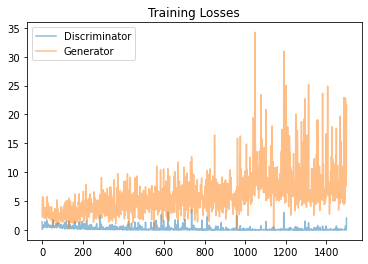

In [73]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [74]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [75]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

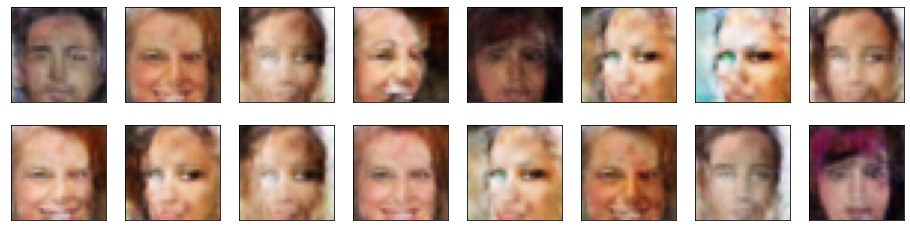

In [76]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

* As noted above biased dataset so it might be harder for the network's training randomization.
* Larger model sizes and better resolution should give better results.
* Optimaztion Startegies:
    * Doubling z-size gives improvement but nbot as much as expected.
    * Increasing number of epochs gives better result.
    * Changing fixed z to random z for each evalution gives better results and smoothness. 

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.